# Cell 0 - Accumulation Signal Sandbox
Explore alternate short-signal formulas using daily_metrics data (read-only). No database writes.

In [5]:
# Cell 1 - Imports and Configuration
from pathlib import Path
import sys

import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Find project root (darkpool/) from Special_tools/ location
notebook_dir = Path.cwd()
if notebook_dir.name == 'Special_tools':
    project_root = notebook_dir.parent
elif (notebook_dir / 'darkpool_analysis').exists():
    project_root = notebook_dir
else:
    # Walk up to find darkpool_analysis
    project_root = notebook_dir
    for _ in range(5):
        if (project_root / 'darkpool_analysis').exists():
            break
        project_root = project_root.parent

if (project_root / 'darkpool_analysis').exists():
    sys.path.insert(0, str(project_root))

from darkpool_analysis.config import load_config

config = load_config()

TICKER = 'XLF'
START_DATE = '2025-10-01'
END_DATE = '2026-01-05'
DB_PATH = config.db_path

DOT_MODE = 'current'  # 'current', 'option_a', 'option_b', 'all'
BLEND_SHORT_WEIGHT = 0.6
BLEND_FLOW_WEIGHT = 0.4

# Median-threshold settings
THRESHOLD_K = 1.5

In [6]:
# Cell 2 - Styling Constants and Helper Functions
import matplotlib.dates as mdates
from scipy.interpolate import PchipInterpolator

COLORS = {
    'background': '#0f0f10',
    'panel_bg': '#141416',
    'text': '#e6e6e6',
    'grid': '#2a2a2d',
    'white': '#ffffff',
    'green': '#00ff88',
    'red': '#ff6b6b',
    'yellow': '#ffd700',
    'cyan': '#00d4ff',
    'orange': '#ff9f43',
    'purple': '#b026ff',
    'neutral': '#6b6b6b',
    'blue': '#4aa3ff',
}
GRID_ALPHA = 0.18
OHLC_LINE_WIDTH = 1.2
SIGNAL_MARKER_SIZE = 60
SIGNAL_EDGE_WIDTH = 0.6
MAIN_LINE_WIDTH = 2.3
MARKER_SIZE = 25

def _apply_axis_style(ax):
    ax.set_facecolor(COLORS['panel_bg'])
    ax.tick_params(colors=COLORS['text'], labelsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(COLORS['grid'])
    ax.spines['bottom'].set_color(COLORS['grid'])
    ax.grid(True, alpha=GRID_ALPHA, color=COLORS['grid'], linestyle='--')

def _format_volume(value):
    if pd.isna(value):
        return 'NA'
    value = float(value)
    if abs(value) >= 1_000_000_000:
        return f'{value / 1_000_000_000:.1f}B'
    if abs(value) >= 1_000_000:
        return f'{value / 1_000_000:.1f}M'
    if abs(value) >= 1_000:
        return f'{value / 1_000:.0f}K'
    return f'{value:,.0f}'

def _rolling_zscore(series, window, min_periods):
    """Compute rolling z-score with safe division."""
    rolling = series.rolling(window=window, min_periods=min_periods)
    mean = rolling.mean()
    std = rolling.std(ddof=0)
    # Avoid division by zero: replace 0 std with NaN
    std = std.replace(0, np.nan)
    return (series - mean) / std

def _sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def _compute_score_display(short_z, lit_z, price_z, otc_z, cfg):
    short = pd.to_numeric(short_z, errors='coerce').to_numpy(dtype=float)
    lit = pd.to_numeric(lit_z, errors='coerce').fillna(0.0).to_numpy(dtype=float)
    price = pd.to_numeric(price_z, errors='coerce').fillna(0.0).to_numpy(dtype=float)
    otc = pd.to_numeric(otc_z, errors='coerce').fillna(0.0).to_numpy(dtype=float)

    score = np.full_like(short, np.nan, dtype=float)
    valid = ~np.isnan(short)
    if valid.any():
        raw = (
            cfg.composite_w_short * np.tanh(short[valid] * 0.5)
            + cfg.composite_w_lit * np.tanh(lit[valid] * 0.5)
            + cfg.composite_w_price * np.tanh(price[valid] * 0.3)
        )
        intensity_range = cfg.intensity_scale_max - cfg.intensity_scale_min
        intensity = cfg.intensity_scale_min + intensity_range * _sigmoid(otc[valid])
        score[valid] = np.clip(raw * intensity, -1.0, 1.0)

    display = (score + 1.0) * 50.0
    return pd.Series(display, index=short_z.index)

def _plot_smooth_line(ax, x_values, values, color, valid_mask, linewidth=MAIN_LINE_WIDTH, alpha=0.85, zorder=3):
    """Plot a smooth PCHIP-interpolated line through valid data points."""
    if valid_mask.sum() >= 3:
        valid_x = x_values[valid_mask]
        valid_values = values[valid_mask]

        x_nums = np.asarray(valid_x, dtype=float)
        x_smooth = np.linspace(x_nums.min(), x_nums.max(), 150)
        interp = PchipInterpolator(x_nums, valid_values.to_numpy() if hasattr(valid_values, 'to_numpy') else np.asarray(valid_values))
        y_smooth = interp(x_smooth)

        ax.plot(
            x_smooth,
            y_smooth,
            color=color,
            linewidth=linewidth,
            alpha=alpha,
            zorder=zorder,
        )
    else:
        ax.plot(
            x_values[valid_mask],
            values[valid_mask],
            color=color,
            linewidth=linewidth,
            alpha=alpha,
            zorder=zorder,
        )

def _set_flow_axis(ax, values):
    series = pd.to_numeric(values, errors='coerce')
    max_abs = series.abs().max(skipna=True)
    if pd.isna(max_abs) or max_abs == 0:
        max_abs = 1.0
    padding = max(max_abs * 0.1, 1.0)
    y_max = max_abs + padding
    y_min = -y_max
    ax.set_ylim(y_min, y_max)
    ax.set_yticks(np.linspace(y_min, y_max, 5))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: _format_volume(x)))
    ax.axhline(0.0, color=COLORS['neutral'], linestyle='--', linewidth=1.2, alpha=0.7)

def _set_ratio_axis(ax, values):
    series = pd.to_numeric(values, errors='coerce')
    max_val = series.max(skipna=True)
    if pd.isna(max_val):
        max_val = 2.0
    upper = max(2.0, float(max_val) * 1.1)
    ax.set_ylim(0, upper)

def _set_volume_axis(ax, values):
    series = pd.to_numeric(values, errors='coerce')
    max_val = series.max(skipna=True)
    if pd.isna(max_val) or max_val <= 0:
        max_val = 1.0
    y_max = max_val * 1.1
    ax.set_ylim(0, y_max)
    ax.set_yticks(np.linspace(0, y_max, 5))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: _format_volume(x)))

def _add_median_thresholds(ax, series, k=1.5, center_override=None):
    values = pd.to_numeric(series, errors='coerce').dropna()
    if values.empty:
        return None, None, None
    center = float(center_override) if center_override is not None else float(values.median())
    deviations = (values - center).abs()
    mad = deviations.median()
    ax.axhline(center, color=COLORS['neutral'], linestyle='--', linewidth=1.0, alpha=0.7)
    ax.text(0.99, center, 'median', transform=ax.get_yaxis_transform(), ha='right', va='bottom', fontsize=7, color=COLORS['neutral'])
    if pd.isna(mad) or mad == 0:
        return center, None, None
    spread = mad * k
    buy = center + spread
    sell = center - spread
    ax.axhline(buy, color=COLORS['green'], linestyle='--', linewidth=1.0, alpha=0.6)
    ax.axhline(sell, color=COLORS['red'], linestyle='--', linewidth=1.0, alpha=0.6)
    return center, buy, sell

DOT_SPECS = {
    'current': {'accum': COLORS['green'], 'dist': COLORS['red'], 'offset': -0.18},
    'option_a': {'accum': COLORS['blue'], 'dist': COLORS['purple'], 'offset': 0.0},
    'option_b': {'accum': COLORS['yellow'], 'dist': COLORS['orange'], 'offset': 0.18},
}

def _plot_ohlc_bars(ax, df_ohlc, x_indices):
    """Plot OHLC bars matching plotter_chart.py style."""
    bar_width = 0.6
    half_width = bar_width / 2

    for xi, (_, row) in zip(x_indices, df_ohlc.iterrows()):
        open_ = row['open']
        high = row['high']
        low = row['low']
        close = row['close']
        if pd.isna(open_) or pd.isna(close) or pd.isna(high) or pd.isna(low):
            continue
        color = COLORS['blue'] if close >= open_ else COLORS['orange']
        ax.vlines(xi, low, high, color=color, linewidth=OHLC_LINE_WIDTH, zorder=3)
        ax.hlines(open_, xi - half_width, xi, color=color, linewidth=OHLC_LINE_WIDTH, zorder=3)
        ax.hlines(close, xi, xi + half_width, color=color, linewidth=OHLC_LINE_WIDTH, zorder=3)

def _plot_ohlc_signal_markers(ax, df_ohlc, scores, x_indices, offset):
    """Plot accumulation/distribution markers on OHLC chart."""
    if scores.isna().all():
        return

    buy_mask = scores >= 70
    sell_mask = scores <= 30
    if buy_mask.any():
        ax.scatter(
            x_indices[buy_mask],
            df_ohlc.loc[buy_mask, 'low'] - offset,
            s=SIGNAL_MARKER_SIZE,
            c=COLORS['green'],
                edgecolors='none',
            linewidths=SIGNAL_EDGE_WIDTH,
            zorder=6,
        )
    if sell_mask.any():
        ax.scatter(
            x_indices[sell_mask],
            df_ohlc.loc[sell_mask, 'high'] + offset,
            s=SIGNAL_MARKER_SIZE,
            c=COLORS['red'],
                edgecolors='none',
            linewidths=SIGNAL_EDGE_WIDTH,
            zorder=6,
        )

def _plot_score_panel(ax, x, scores, confidence, title, dot_mode, dot_sources, force_self_dots=False):
    from matplotlib.colors import LinearSegmentedColormap

    score_cmap = LinearSegmentedColormap.from_list(
        'score_cmap',
        [
            (0.0, COLORS['purple']),
            (0.5, '#555555'),
            (1.0, COLORS['green']),
        ],
    )

    scores_filled = scores.fillna(50)
    conf_filled = confidence.fillna(0.5)

    for xi, score, conf, score_raw in zip(x, scores_filled, conf_filled, scores):
        norm_score = np.clip(score / 100.0, 0, 1)
        dev = norm_score - 0.5
        norm_score = 0.5 + np.sign(dev) * (abs(dev) ** 0.85)
        norm_score = np.clip(norm_score, 0, 1)
        bar_color = score_cmap(norm_score)
        alpha = 0.8 if conf >= 0.6 else 0.4
        bar_height = score / 100.0
        ax.bar(xi, bar_height, bottom=0, color=bar_color, alpha=alpha, width=0.72, zorder=2)

        if not pd.isna(score_raw):
            label_y = max(bar_height / 2, 0.12)
            ax.text(
                xi,
                label_y,
                f'{score:.0f}',
                ha='center',
                va='center',
                fontsize=7,
                color=COLORS['white'],
                zorder=4,
            )


        conf_height = 0.08 * conf
        if conf >= 0.7:
            conf_color = COLORS['green']
        elif conf >= 0.4:
            conf_color = COLORS['yellow']
        else:
            conf_color = COLORS['red']
        ax.bar(xi, conf_height, bottom=-0.12, color=conf_color, alpha=0.6, width=0.54, zorder=3)

    ax.axhline(y=0.30, color=COLORS['red'], linestyle='--', linewidth=0.8, alpha=0.4, zorder=1)
    ax.axhline(y=0.50, color=COLORS['neutral'], linestyle='--', linewidth=0.8, alpha=0.4, zorder=1)
    ax.axhline(y=0.70, color=COLORS['green'], linestyle='--', linewidth=0.8, alpha=0.4, zorder=1)
    ax.set_ylim(-0.15, 1.08)
    ax.set_yticks([0, 0.3, 0.5, 0.7, 1.0])
    ax.set_yticklabels(['0', '30', '50', '70', '100'])
    ax.set_title(title, color=COLORS['text'], fontsize=10, fontweight='bold', loc='left')

    dot_mode = dot_mode or 'current'
    if dot_mode == 'all':
        dot_keys = ['current', 'option_a', 'option_b']
    else:
        dot_keys = [dot_mode]

    dot_pad = 0.07
    if force_self_dots:
        series = pd.to_numeric(scores, errors='coerce')
        accum_mask = (series >= 70).to_numpy()
        dist_mask = (series <= 30).to_numpy()
        if accum_mask.any():
            y_vals = (series[accum_mask] / 100.0) + dot_pad
            y_vals = np.minimum(y_vals, 1.04)
            ax.scatter(
                x[accum_mask],
                y_vals.to_numpy(),
                s=60,
                c=COLORS['green'],
                edgecolors='none',
                linewidths=0.0,
                zorder=6,
            )
        if dist_mask.any():
            y_vals = (series[dist_mask] / 100.0) + dot_pad
            y_vals = np.minimum(y_vals, 1.04)
            ax.scatter(
                x[dist_mask],
                y_vals.to_numpy(),
                s=60,
                c=COLORS['red'],
                edgecolors='none',
                linewidths=0.0,
                zorder=6,
            )
        return
    for key in dot_keys:
        series = dot_sources.get(key)
        if series is None:
            continue
        series = pd.to_numeric(series, errors='coerce')
        spec = DOT_SPECS.get(key, DOT_SPECS['current'])
        offset = spec['offset'] if dot_mode == 'all' else 0.0
        accum_mask = (series >= 70).to_numpy()
        dist_mask = (series <= 30).to_numpy()
        if accum_mask.any():
            y_vals = (series[accum_mask] / 100.0) + dot_pad
            y_vals = np.minimum(y_vals, 1.04)
            ax.scatter(
                x[accum_mask] + offset,
                y_vals.to_numpy(),
                s=60,
                c=spec['accum'],
                edgecolors='none',
                linewidths=0.0,
                zorder=6,
            )
        if dist_mask.any():
            y_vals = (series[dist_mask] / 100.0) + dot_pad
            y_vals = np.minimum(y_vals, 1.04)
            ax.scatter(
                x[dist_mask] + offset,
                y_vals.to_numpy(),
                s=60,
                c=spec['dist'],
                edgecolors='none',
                linewidths=0.0,
                zorder=6,
            )

In [7]:
# Cell 3 - Data Loading and Processing
query = '''
    SELECT
        date,
        symbol,
        finra_buy_volume,
        short_sell_volume,
        short_buy_sell_ratio,
        short_buy_sell_ratio_z,
        finra_buy_volume_z,
        lit_buy_volume,
        lit_sell_volume,
        lit_buy_ratio,
        lit_flow_imbalance,
        lit_flow_imbalance_z,
        return_z,
        otc_participation_z,
        confidence
    FROM daily_metrics
    WHERE symbol = ? AND date BETWEEN ? AND ?
    ORDER BY date
'''

ohlc_query = '''
    SELECT
        trade_date AS date,
        open,
        high,
        low,
        close,
        volume
    FROM polygon_daily_agg_raw
    WHERE symbol = ? AND trade_date BETWEEN ? AND ?
    ORDER BY trade_date
'''

with duckdb.connect(str(DB_PATH)) as conn:
    df = conn.execute(query, [TICKER.upper(), START_DATE, END_DATE]).df()
    df_ohlc = conn.execute(ohlc_query, [TICKER.upper(), START_DATE, END_DATE]).df()

if df.empty:
    raise ValueError(f'No data found for {TICKER} between {START_DATE} and {END_DATE}.')

df['date'] = pd.to_datetime(df['date'])
numeric_cols = [
    'finra_buy_volume',
    'short_sell_volume',
    'short_buy_sell_ratio',
    'short_buy_sell_ratio_z',
    'finra_buy_volume_z',
    'lit_buy_volume',
    'lit_sell_volume',
    'lit_buy_ratio',
    'lit_flow_imbalance',
    'lit_flow_imbalance_z',
    'return_z',
    'otc_participation_z',
    'confidence',
]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Process OHLC data
if not df_ohlc.empty:
    df_ohlc['date'] = pd.to_datetime(df_ohlc['date'])
    for col in ['open', 'high', 'low', 'close', 'volume']:
        if col in df_ohlc.columns:
            df_ohlc[col] = pd.to_numeric(df_ohlc[col], errors='coerce')
    # Merge OHLC with metrics on date
    df = df.merge(df_ohlc, on='date', how='left')
else:
    df['open'] = np.nan
    df['high'] = np.nan
    df['low'] = np.nan
    df['close'] = np.nan
    df['volume'] = np.nan

# Use finra_buy_volume directly (was: short_buy_volume)
short_buy = df['finra_buy_volume'].fillna(0.0)
short_sell = df['short_sell_volume'].fillna(0.0)
lit_buy = df['lit_buy_volume'].fillna(0.0)
lit_sell = df['lit_sell_volume'].fillna(0.0)
total_buy = short_buy + lit_buy
total_sell = short_sell + lit_sell

# Compute combined ratio
df['combined_ratio'] = np.nan
valid_ratio = total_sell > 0
df.loc[valid_ratio, 'combined_ratio'] = total_buy[valid_ratio] / total_sell[valid_ratio]
df['combined_ratio'] = pd.to_numeric(df['combined_ratio'], errors='coerce')

# Compute VW flow
df['vw_flow'] = np.nan
has_flow = (short_buy > 0) | (short_sell > 0) | (lit_buy > 0) | (lit_sell > 0)
df.loc[has_flow, 'vw_flow'] = total_buy[has_flow] - total_sell[has_flow]
df['vw_flow'] = pd.to_numeric(df['vw_flow'], errors='coerce')

# Compute Lit Buy/Sell Ratio (NEW for Panel 3)
df['lit_buy_sell_ratio'] = np.nan
valid_lit = lit_sell > 0
df.loc[valid_lit, 'lit_buy_sell_ratio'] = lit_buy[valid_lit] / lit_sell[valid_lit]
df['lit_buy_sell_ratio'] = df['lit_buy_sell_ratio'].replace([np.inf, -np.inf], np.nan)

# Fallback: compute short_buy_sell_ratio if missing
if df['short_buy_sell_ratio'].isna().all():
    valid = df['short_sell_volume'] > 0
    df.loc[valid, 'short_buy_sell_ratio'] = df.loc[valid, 'finra_buy_volume'] / df.loc[valid, 'short_sell_volume']

# Fallback: compute short_buy_sell_ratio_z if missing
if df['short_buy_sell_ratio_z'].isna().all():
    df['short_buy_sell_ratio_z'] = _rolling_zscore(
        df['short_buy_sell_ratio'], config.short_z_window, config.zscore_min_periods
    )

# Fallback: compute finra_buy_volume_z if missing
if df['finra_buy_volume_z'].isna().all():
    df['finra_buy_volume_z'] = _rolling_zscore(
        df['finra_buy_volume'], config.short_z_window, config.zscore_min_periods
    )

# Compute VW flow z-score
df['vw_flow_z'] = _rolling_zscore(df['vw_flow'], config.short_z_window, config.zscore_min_periods)

# Get lit z-score (with fallback)
lit_z = df['lit_flow_imbalance_z'].copy()
if lit_z.isna().all():
    lit_z = _rolling_zscore(df['lit_flow_imbalance'], config.short_z_window, config.zscore_min_periods)

price_z = df['return_z'].fillna(0.0)
otc_z = df['otc_participation_z'].fillna(0.0)

# =============================================================================
# EXPERIMENT SCORES (A, B, C, D)
# =============================================================================

# Experiment A: VWBR-Anchored (finra_buy_volume_z)
df['acc_score_a'] = _compute_score_display(
    df['finra_buy_volume_z'], lit_z, price_z, otc_z, config
)

# Experiment B: Short Buy/Sell Ratio (current production)
df['acc_score_b'] = _compute_score_display(
    df['short_buy_sell_ratio_z'], lit_z, price_z, otc_z, config
)

# Experiment C: Combined (50/50 blend of VWBR_z + Ratio_z)
blended_z = 0.5 * df['finra_buy_volume_z'].fillna(0.0) + 0.5 * df['short_buy_sell_ratio_z'].fillna(0.0)
df['acc_score_c'] = _compute_score_display(
    blended_z, lit_z, price_z, otc_z, config
)

# Experiment D: Exploratory (Imbalance-Weighted)
B = df['finra_buy_volume'].fillna(0)
S = df['short_sell_volume'].fillna(0)
total = B + S
imbalance = np.where(total > 0, (B - S) / total, 0)
imbalance_signal = imbalance * np.log1p(total)
df['imbalance_signal'] = imbalance_signal
imbalance_z = _rolling_zscore(pd.Series(imbalance_signal, index=df.index), config.short_z_window, config.zscore_min_periods)
df['acc_score_d'] = _compute_score_display(
    imbalance_z, lit_z, price_z, otc_z, config
)

df['confidence'] = df['confidence'].fillna(0.5)
print(f"Loaded {len(df)} rows for {TICKER}")
df.head()

Loaded 61 rows for XLF


,date,symbol,finra_buy_volume,short_sell_volume,short_buy_sell_ratio,short_buy_sell_ratio_z,finra_buy_volume_z,lit_buy_volume,lit_sell_volume,lit_buy_ratio,...,volume,combined_ratio,vw_flow,lit_buy_sell_ratio,vw_flow_z,acc_score_a,acc_score_b,acc_score_c,imbalance_signal,acc_score_d
0,2025-10-08,XLF,3449111.0,3193260.0,1.080122,NaN,NaN,3239895.0,1640153.0,0.663906,...,26848679.0,1.383909,1855593.0,1.975361,NaN,NaN,NaN,50.0,0.605079,NaN
1,2025-10-09,XLF,4410866.0,4895667.0,0.900973,NaN,NaN,3608238.0,3521097.0,0.506111,...,33922435.0,0.952754,-397660.0,1.024748,NaN,NaN,NaN,50.0,-0.835889,NaN
2,2025-10-10,XLF,5876059.0,5449628.0,1.078250,NaN,NaN,6313668.0,7494806.0,0.457231,...,73596160.0,0.941696,-754707.0,0.842406,NaN,NaN,NaN,50.0,0.611560,NaN
3,2025-10-13,XLF,5662148.0,6372925.0,0.888469,NaN,NaN,3862869.0,3477345.0,0.526261,...,39651855.0,0.966980,-325253.0,1.110867,NaN,NaN,NaN,50.0,-0.962855,NaN
4,2025-10-14,XLF,8150311.0,5561366.0,1.465523,NaN,NaN,8209615.0,4177485.0,0.662755,...,62588716.0,1.679862,6621075.0,1.965205,1.886076,NaN,NaN,50.0,3.102910,69.526276


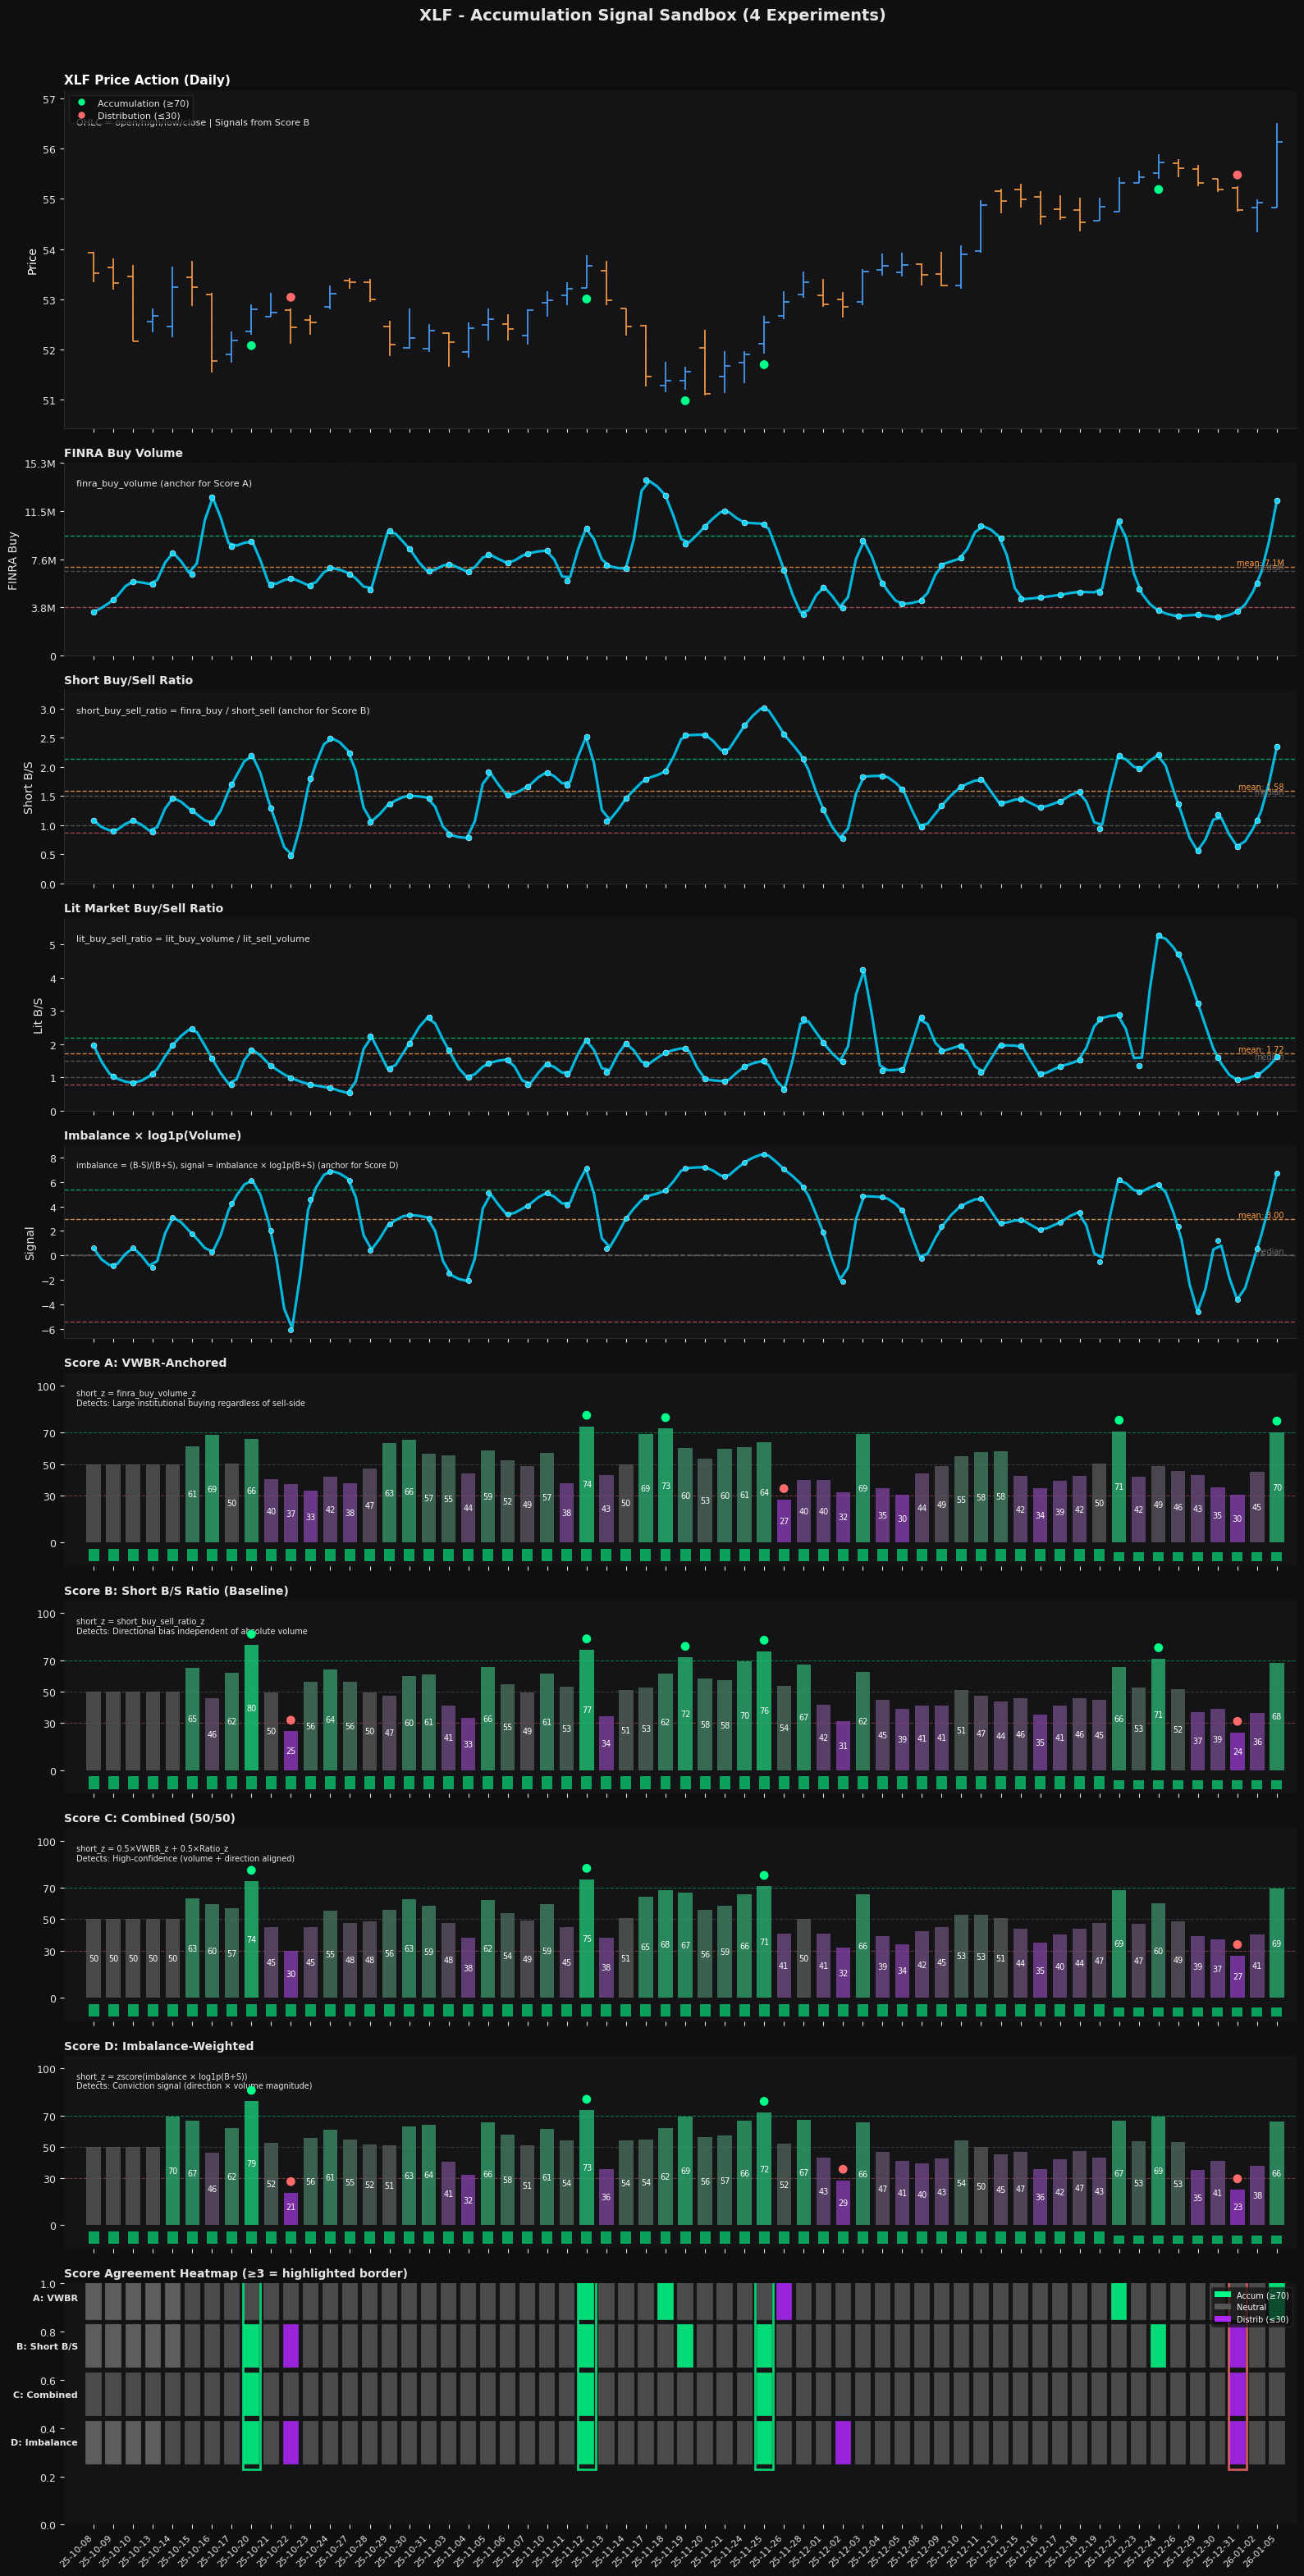

In [8]:
# Cell 4 - Main Visualization (10-Panel Chart with OHLC)
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Rectangle
from matplotlib.colors import LinearSegmentedColormap

plt.style.use('dark_background')
fig, axes = plt.subplots(
    10,
    1,
    figsize=(16, 32),
    sharex=True,
    gridspec_kw={'height_ratios': [3.5, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.5]},
)
fig.patch.set_facecolor(COLORS['background'])

x = np.arange(len(df))
labels = df['date'].dt.strftime('%y-%m-%d').tolist()

# Panel 0: OHLC Price Chart with Signal Markers
ax = axes[0]
_apply_axis_style(ax)
_plot_ohlc_bars(ax, df, x)

# Calculate y-axis range and signal marker offset
y_min = df['low'].min()
y_max = df['high'].max()
if pd.isna(y_min) or pd.isna(y_max):
    y_min = df['close'].min()
    y_max = df['close'].max()
y_span = y_max - y_min if pd.notna(y_max) and pd.notna(y_min) else 0
if not y_span or y_span <= 0:
    y_span = float(df['close'].mean() or 1.0)
offset = y_span * 0.04

# Plot signal markers using Score B (Short B/S Ratio - production baseline)
_plot_ohlc_signal_markers(ax, df, df['acc_score_b'], x, offset)
ax.set_ylim(y_min - offset * 3, y_max + offset * 3)
ax.set_ylabel('Price', color=COLORS['white'], fontsize=10)
ax.set_title(f'{TICKER} Price Action (Daily)', color=COLORS['white'], fontsize=11, fontweight='bold', loc='left')
ax.text(0.01, 0.92, 'OHLC = open/high/low/close | Signals from Score B', transform=ax.transAxes, fontsize=8, color=COLORS['text'], va='top')

# Add legend for OHLC panel
legend_handles = [
    Line2D([0], [0], marker='o', color='none', markerfacecolor=COLORS['green'],
           markeredgecolor='none', markersize=6, label='Accumulation (≥70)'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=COLORS['red'],
           markeredgecolor='none', markersize=6, label='Distribution (≤30)'),
]
legend = ax.legend(
    handles=legend_handles,
    loc='upper left',
    fontsize=8,
    frameon=True,
    facecolor=COLORS['background'],
    framealpha=0.7,
    edgecolor=COLORS['grid'],
)
for text in legend.get_texts():
    text.set_color(COLORS['text'])


# Panel 1: FINRA Buy Volume (B)
ax = axes[1]
_apply_axis_style(ax)
series = df['finra_buy_volume']
mask = series.notna()
_plot_smooth_line(ax, x, series, COLORS['cyan'], mask, linewidth=MAIN_LINE_WIDTH)
ax.scatter(x[mask], series[mask], color=COLORS['cyan'], s=MARKER_SIZE, edgecolors=COLORS['white'], linewidths=0.4, zorder=5)
_set_volume_axis(ax, series)
_add_median_thresholds(ax, series, k=THRESHOLD_K)
series_mean = series.mean(skipna=True)
if not pd.isna(series_mean):
    ax.axhline(y=series_mean, color=COLORS['orange'], linestyle='--', linewidth=1.0, alpha=0.8, zorder=2)
    ax.text(0.99, series_mean, f'mean: {_format_volume(series_mean)}', transform=ax.get_yaxis_transform(), ha='right', va='bottom', fontsize=7, color=COLORS['orange'])
ax.set_ylabel('FINRA Buy', color=COLORS['text'])
ax.set_title('FINRA Buy Volume', color=COLORS['text'], fontsize=10, fontweight='bold', loc='left')
ax.text(0.01, 0.92, 'finra_buy_volume (anchor for Score A)', transform=ax.transAxes, fontsize=8, color=COLORS['text'], va='top')


# Panel 2: Short Buy/Sell Ratio
ax = axes[2]
_apply_axis_style(ax)
series = df['short_buy_sell_ratio']
mask = series.notna()
_plot_smooth_line(ax, x, series, COLORS['cyan'], mask, linewidth=MAIN_LINE_WIDTH)
ax.scatter(x[mask], series[mask], color=COLORS['cyan'], s=MARKER_SIZE, edgecolors=COLORS['white'], linewidths=0.4, zorder=5)
_set_ratio_axis(ax, series)
ax.axhline(1.0, color=COLORS['neutral'], linestyle='--', linewidth=1.0, alpha=0.7)
_add_median_thresholds(ax, series, k=THRESHOLD_K)
series_mean = series.mean(skipna=True)
if not pd.isna(series_mean):
    ax.axhline(y=series_mean, color=COLORS['orange'], linestyle='--', linewidth=1.0, alpha=0.8, zorder=2)
    ax.text(0.99, series_mean, f'mean: {series_mean:.2f}', transform=ax.get_yaxis_transform(), ha='right', va='bottom', fontsize=7, color=COLORS['orange'])
ax.set_ylabel('Short B/S', color=COLORS['text'])
ax.set_title('Short Buy/Sell Ratio', color=COLORS['text'], fontsize=10, fontweight='bold', loc='left')
ax.text(0.01, 0.92, 'short_buy_sell_ratio = finra_buy / short_sell (anchor for Score B)', transform=ax.transAxes, fontsize=8, color=COLORS['text'], va='top')


# Panel 3: Lit Buy/Sell Ratio (NEW - replaces VW Flow)
ax = axes[3]
_apply_axis_style(ax)
series = df['lit_buy_sell_ratio']
mask = series.notna()
_plot_smooth_line(ax, x, series, COLORS['cyan'], mask, linewidth=MAIN_LINE_WIDTH)
ax.scatter(x[mask], series[mask], color=COLORS['cyan'], s=MARKER_SIZE, edgecolors=COLORS['white'], linewidths=0.4, zorder=5)
_set_ratio_axis(ax, series)
ax.axhline(1.0, color=COLORS['neutral'], linestyle='--', linewidth=1.0, alpha=0.7)
_add_median_thresholds(ax, series, k=THRESHOLD_K)
series_mean = series.mean(skipna=True)
if not pd.isna(series_mean):
    ax.axhline(y=series_mean, color=COLORS['orange'], linestyle='--', linewidth=1.0, alpha=0.8, zorder=2)
    ax.text(0.99, series_mean, f'mean: {series_mean:.2f}', transform=ax.get_yaxis_transform(), ha='right', va='bottom', fontsize=7, color=COLORS['orange'])
ax.set_ylabel('Lit B/S', color=COLORS['text'])
ax.set_title('Lit Market Buy/Sell Ratio', color=COLORS['text'], fontsize=10, fontweight='bold', loc='left')
ax.text(0.01, 0.92, 'lit_buy_sell_ratio = lit_buy_volume / lit_sell_volume', transform=ax.transAxes, fontsize=8, color=COLORS['text'], va='top')


# Panel 4: Imbalance Signal (for Score D)
ax = axes[4]
_apply_axis_style(ax)
series = df['imbalance_signal']
mask = series.notna()
_plot_smooth_line(ax, x, series, COLORS['cyan'], mask, linewidth=MAIN_LINE_WIDTH)
ax.scatter(x[mask], series[mask], color=COLORS['cyan'], s=MARKER_SIZE - 5, edgecolors=COLORS['white'], linewidths=0.4, zorder=5)
ax.axhline(0.0, color=COLORS['neutral'], linestyle='--', linewidth=1.2, alpha=0.7)
_add_median_thresholds(ax, series, k=THRESHOLD_K, center_override=0.0)
series_mean = series.mean(skipna=True)
if not pd.isna(series_mean):
    ax.axhline(y=series_mean, color=COLORS['orange'], linestyle='--', linewidth=1.0, alpha=0.8, zorder=2)
    ax.text(0.99, series_mean, f'mean: {series_mean:.2f}', transform=ax.get_yaxis_transform(), ha='right', va='bottom', fontsize=7, color=COLORS['orange'])
ax.set_ylabel('Signal', color=COLORS['text'])
ax.set_title('Imbalance × log1p(Volume)', color=COLORS['text'], fontsize=10, fontweight='bold', loc='left')
ax.text(0.01, 0.92, 'imbalance = (B-S)/(B+S), signal = imbalance × log1p(B+S) (anchor for Score D)', transform=ax.transAxes, fontsize=7, color=COLORS['text'], va='top')


# Shared dot sources for all score panels
dot_sources = {
    'current': df['acc_score_b'],  # Use Score B as "current" reference
    'option_a': df['acc_score_a'],
    'option_b': df['acc_score_c'],
}

# Panel 5: Score A - VWBR (finra_buy_volume_z)
ax = axes[5]
ax.set_facecolor(COLORS['panel_bg'])
ax.tick_params(colors=COLORS['text'], labelsize=9)
for spine in ax.spines.values():
    spine.set_visible(False)
_plot_score_panel(ax, x, df['acc_score_a'], df['confidence'], 'Score A: VWBR-Anchored', DOT_MODE, dot_sources, force_self_dots=True)
ax.text(0.01, 0.92, 'short_z = finra_buy_volume_z\nDetects: Large institutional buying regardless of sell-side', transform=ax.transAxes, fontsize=7, color=COLORS['text'], va='top')


# Panel 6: Score B - Short Buy/Sell Ratio (Production Baseline)
ax = axes[6]
ax.set_facecolor(COLORS['panel_bg'])
ax.tick_params(colors=COLORS['text'], labelsize=9)
for spine in ax.spines.values():
    spine.set_visible(False)
_plot_score_panel(ax, x, df['acc_score_b'], df['confidence'], 'Score B: Short B/S Ratio (Baseline)', DOT_MODE, dot_sources, force_self_dots=True)
ax.text(0.01, 0.92, 'short_z = short_buy_sell_ratio_z\nDetects: Directional bias independent of absolute volume', transform=ax.transAxes, fontsize=7, color=COLORS['text'], va='top')


# Panel 7: Score C - Combined (50/50 Blend)
ax = axes[7]
ax.set_facecolor(COLORS['panel_bg'])
ax.tick_params(colors=COLORS['text'], labelsize=9)
for spine in ax.spines.values():
    spine.set_visible(False)
_plot_score_panel(ax, x, df['acc_score_c'], df['confidence'], 'Score C: Combined (50/50)', DOT_MODE, dot_sources, force_self_dots=True)
ax.text(0.01, 0.92, 'short_z = 0.5×VWBR_z + 0.5×Ratio_z\nDetects: High-confidence (volume + direction aligned)', transform=ax.transAxes, fontsize=7, color=COLORS['text'], va='top')


# Panel 8: Score D - Exploratory (Imbalance-Weighted)
ax = axes[8]
ax.set_facecolor(COLORS['panel_bg'])
ax.tick_params(colors=COLORS['text'], labelsize=9)
for spine in ax.spines.values():
    spine.set_visible(False)
_plot_score_panel(ax, x, df['acc_score_d'], df['confidence'], 'Score D: Imbalance-Weighted', DOT_MODE, dot_sources, force_self_dots=True)
ax.text(0.01, 0.92, 'short_z = zscore(imbalance × log1p(B+S))\nDetects: Conviction signal (direction × volume magnitude)', transform=ax.transAxes, fontsize=7, color=COLORS['text'], va='top')


# Panel 9: Agreement Heatmap (NEW)
ax = axes[9]
ax.set_facecolor(COLORS['panel_bg'])
ax.tick_params(colors=COLORS['text'], labelsize=9)
for spine in ax.spines.values():
    spine.set_visible(False)

# Build score matrix: rows = experiments, cols = days
scores_matrix = np.array([
    df['acc_score_a'].values,
    df['acc_score_b'].values,
    df['acc_score_c'].values,
    df['acc_score_d'].values,
])

# Color mapping function
def get_cell_color(score):
    if pd.isna(score):
        return COLORS['neutral']
    if score >= 70:
        return COLORS['green']
    if score <= 30:
        return COLORS['purple']
    return '#555555'  # Grey for neutral

# Draw heatmap cells
row_labels = ['A: VWBR', 'B: Short B/S', 'C: Combined', 'D: Imbalance']
cell_height = 0.18
y_start = 0.85

for row_idx, label in enumerate(row_labels):
    y_pos = y_start - row_idx * (cell_height + 0.02)
    
    # Row label
    ax.text(-0.8, y_pos + cell_height/2, label, ha='right', va='center',
            fontsize=8, color=COLORS['text'], fontweight='bold')
    
    # Draw cells for each day
    for col_idx in range(len(df)):
        score = scores_matrix[row_idx, col_idx]
        color = get_cell_color(score)
        rect = Rectangle((col_idx - 0.4, y_pos), 0.8, cell_height,
                         facecolor=color, edgecolor=COLORS['grid'], linewidth=0.3, alpha=0.85)
        ax.add_patch(rect)

# Highlight columns where 3+ scores agree on direction
for col_idx in range(len(df)):
    col_scores = scores_matrix[:, col_idx]
    accum_count = np.sum(col_scores >= 70)
    dist_count = np.sum(col_scores <= 30)
    
    if accum_count >= 3:
        # Strong accumulation agreement - white border
        rect = Rectangle((col_idx - 0.45, y_start - 3*(cell_height+0.02) - 0.02), 
                         0.9, 4*(cell_height+0.02),
                         facecolor='none', edgecolor=COLORS['green'], linewidth=2, alpha=0.8)
        ax.add_patch(rect)
    elif dist_count >= 3:
        # Strong distribution agreement - white border
        rect = Rectangle((col_idx - 0.45, y_start - 3*(cell_height+0.02) - 0.02), 
                         0.9, 4*(cell_height+0.02),
                         facecolor='none', edgecolor=COLORS['red'], linewidth=2, alpha=0.8)
        ax.add_patch(rect)

ax.set_xlim(-1.5, len(df))
ax.set_ylim(0, 1.0)
ax.set_title('Score Agreement Heatmap (≥3 = highlighted border)', color=COLORS['text'], fontsize=10, fontweight='bold', loc='left')

# Add legend for heatmap
legend_elements = [
    Patch(facecolor=COLORS['green'], edgecolor='none', label='Accum (≥70)'),
    Patch(facecolor='#555555', edgecolor='none', label='Neutral'),
    Patch(facecolor=COLORS['purple'], edgecolor='none', label='Distrib (≤30)'),
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=7,
          frameon=True, facecolor=COLORS['background'], framealpha=0.7, edgecolor=COLORS['grid'])


# Set x-axis labels
axes[-1].set_xticks(x)
axes[-1].set_xticklabels(labels, rotation=45, ha='right', fontsize=8)

fig.suptitle(f'{TICKER} - Accumulation Signal Sandbox (4 Experiments)', color=COLORS['text'], fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()